# Análisis gráfico del modelo de Fama-French para AAPL

En este notebook:

1. Descargamos los factores de Fama-French (daily) con `pandas_datareader`.
2. Descargamos precios de AAPL con `yfinance`.
3. Calculamos rendimientos diarios.
4. Visualizamos:
   - Precio de AAPL.
   - Rendimientos de AAPL.
   - Factores Fama-French.
   - Correlaciones entre factores y rendimientos.
5. Ajustamos el modelo Fama-French:
   
   \[
   R_{AAPL} - R_f = \alpha + \beta_{Mkt} (Mkt-RF) + \beta_{SMB} SMB + \beta_{HML} HML + \varepsilon
   \]

6. Graficamos:
   - Rendimiento en exceso vs. factor de mercado (con recta ajustada).
   - Rendimiento en exceso observado vs. predicho.
   - Residuales del modelo.




In [125]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import statsmodels.api as sm
from pandas_datareader import data as web
plt.style.use("seaborn-v0_8")

#Trabajaremos desde 2015 a la fecha

In [126]:
inicio = "2015-01-01"
fin = "2025-10-31"


In [127]:
ff = web.DataReader("F-F_Research_Data_Factors_Daily", "famafrench")

factores = ff[0].copy()
factores = factores.loc[inicio:fin]
factores = factores / 100.0

factores.head()


/tmp/ipython-input-650348512.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors_Daily", "famafrench")


,Mkt-RF,SMB,HML,RF
Date,,,,
2020-11-20,-0.0051,0.0067,-0.0060,0.0
2020-11-23,0.0082,0.0088,0.0155,0.0
2020-11-24,0.0156,-0.0012,0.0278,0.0
2020-11-25,0.0002,0.0000,-0.0132,0.0
2020-11-27,0.0042,0.0046,-0.0162,0.0


#Factores de tiempo

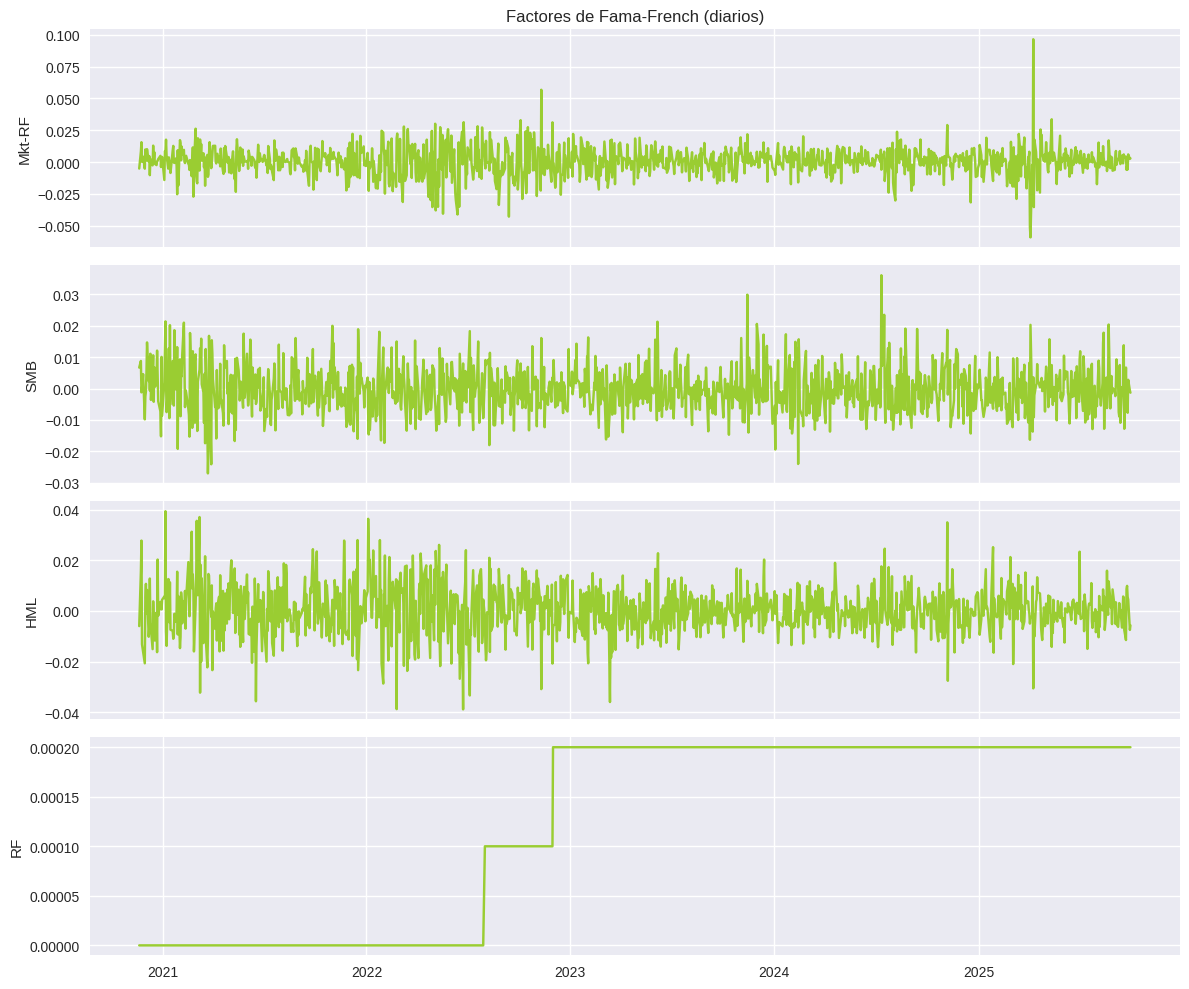

In [178]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
columnas = ["Mkt-RF", "SMB", "HML", "RF"]

for ax, col in zip(axes, columnas):
    ax.plot(factores.index, factores[col], color="yellowgreen")
    ax.set_ylabel(col)
    ax.grid(True)

axes[0].set_title("Factores de Fama-French (diarios)")
plt.tight_layout()
plt.show()


#Obteniendo datos de AAPL

In [130]:
datos_aapl = yf.download("AAPL", start=inicio, end=fin, auto_adjust=False, multi_level_index=False)
datos_aapl


[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,24.237553,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05,23.554741,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06,23.556957,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07,23.887278,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08,24.805069,27.972500,28.037500,27.174999,27.307501,237458000
...,...,...,...,...,...,...
2025-10-24,262.565491,262.820007,264.130005,259.179993,261.190002,38253700
2025-10-27,268.549652,268.809998,269.119995,264.649994,264.880005,44888200
2025-10-28,268.739471,269.000000,269.890015,268.149994,268.989990,41534800


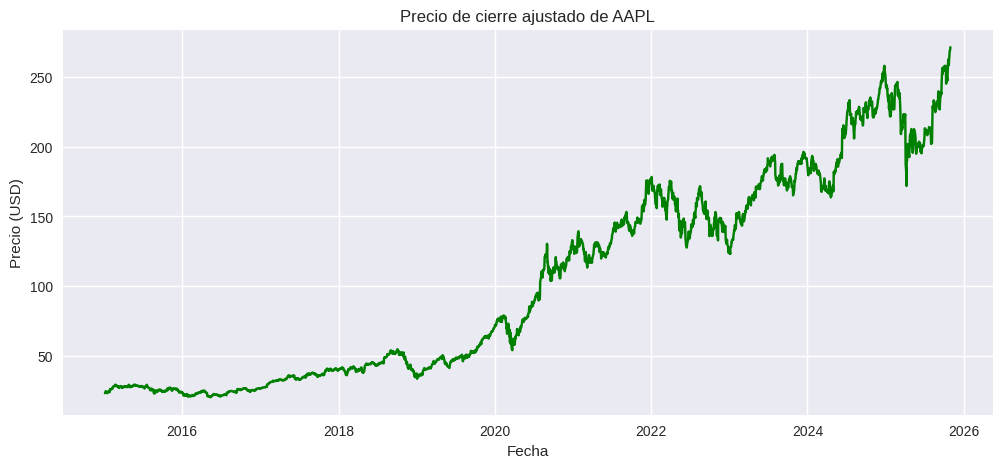

In [144]:
plt.figure(figsize=(12, 5))
plt.plot(datos_aapl.index, datos_aapl["Adj Close"],color="green")
plt.title("Precio de cierre ajustado de AAPL")
plt.ylabel("Precio (USD)")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()


In [140]:
datos_aapl["rend_aapl"] = np.log(
    datos_aapl["Adj Close"] / datos_aapl["Adj Close"].shift(1)
)
datos_aapl = datos_aapl.dropna(subset=["rend_aapl"])
datos_aapl[["Adj Close", "rend_aapl"]].head()


,Adj Close,rend_aapl
Date,,
2015-01-05,23.554741,-0.028576
2015-01-06,23.556957,0.000094
2015-01-07,23.887278,0.013925
2015-01-08,24.805069,0.037702
2015-01-09,24.831682,0.001072


#Rendimientos logarítmicos de AAPL

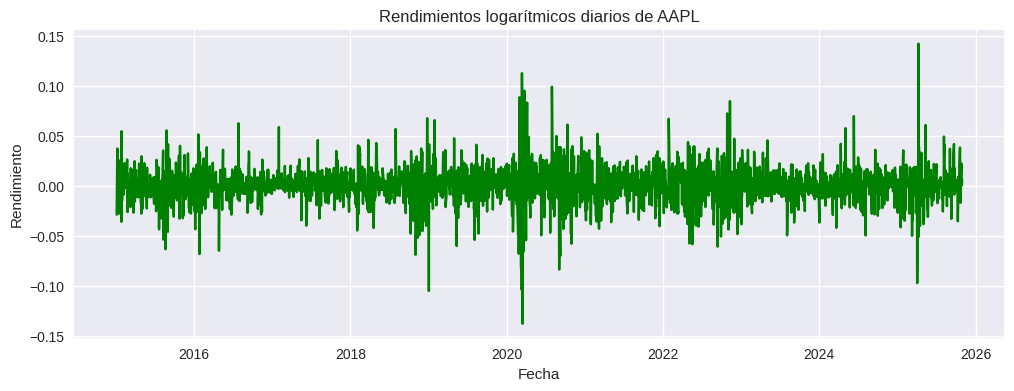

In [145]:
plt.figure(figsize=(12, 4))
plt.plot(datos_aapl.index, datos_aapl["rend_aapl"], color="green")
plt.title("Rendimientos logarítmicos diarios de AAPL")
plt.ylabel("Rendimiento")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()


Histograma de rendimientos

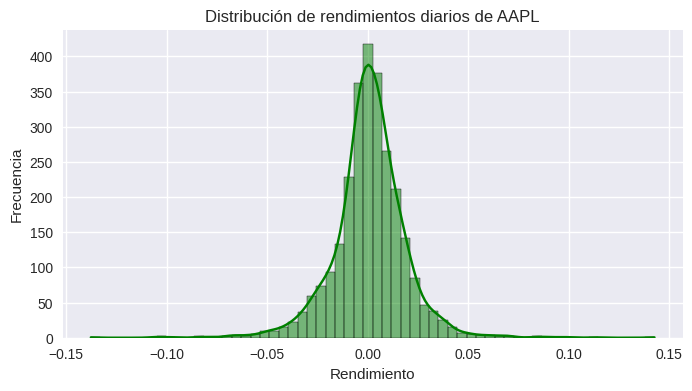

In [143]:
plt.figure(figsize=(8, 4))
sns.histplot(datos_aapl["rend_aapl"], bins=60, kde=True, color="green")
plt.title("Distribución de rendimientos diarios de AAPL")
plt.xlabel("Rendimiento")
plt.ylabel("Frecuencia")
plt.show()


#Unir AAPL con Fama-French

In [146]:
datos = pd.merge(
    datos_aapl[["rend_aapl"]],
    factores,
    left_index=True,
    right_index=True,
    how="inner"
)

datos.head()


,rend_aapl,Mkt-RF,SMB,HML,RF
Date,,,,,
2020-11-20,-0.011018,-0.0051,0.0067,-0.0060,0.0
2020-11-23,-0.030194,0.0082,0.0088,0.0155,0.0
2020-11-24,0.011528,0.0156,-0.0012,0.0278,0.0
2020-11-25,0.007439,0.0002,0.0000,-0.0132,0.0
2020-11-27,0.004815,0.0042,0.0046,-0.0162,0.0


#Matriz de correlaciones

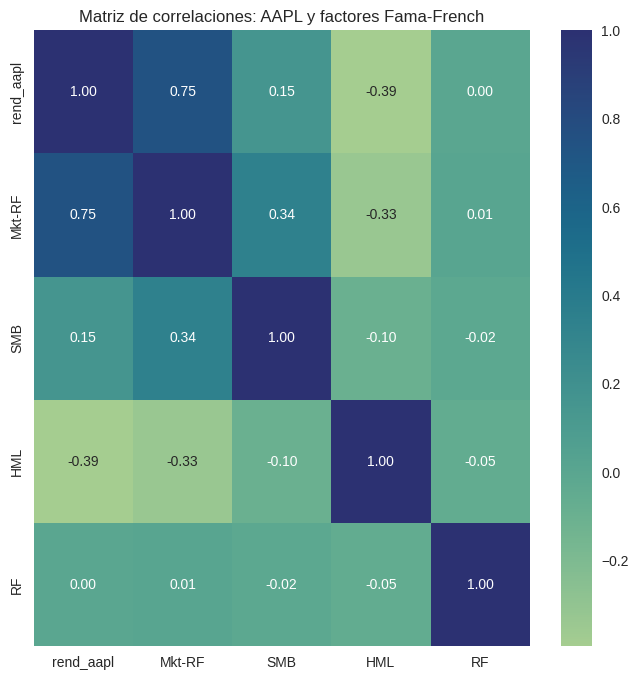

In [150]:
corr = datos[["rend_aapl", "Mkt-RF", "SMB", "HML", "RF"]].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="crest", fmt=".2f")
plt.title("Matriz de correlaciones: AAPL y factores Fama-French")
plt.show()


#Rendimiento en exceso de AAPL

In [151]:
datos["rend_exceso_aapl"] = datos["rend_aapl"] - datos["RF"]
datos[["rend_aapl", "RF", "rend_exceso_aapl"]].head()


,rend_aapl,RF,rend_exceso_aapl
Date,,,
2020-11-20,-0.011018,0.0,-0.011018
2020-11-23,-0.030194,0.0,-0.030194
2020-11-24,0.011528,0.0,0.011528
2020-11-25,0.007439,0.0,0.007439
2020-11-27,0.004815,0.0,0.004815


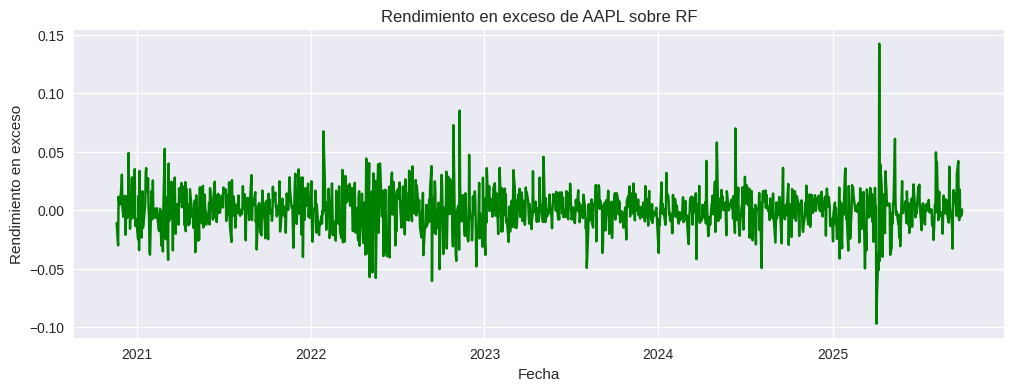

In [153]:
plt.figure(figsize=(12, 4))
plt.plot(datos.index, datos["rend_exceso_aapl"], color="green")
plt.title("Rendimiento en exceso de AAPL sobre RF")
plt.ylabel("Rendimiento en exceso")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()


# Preparamos datos para el modelo Fama-French

In [154]:
X = datos[["Mkt-RF", "SMB", "HML"]]
X = sm.add_constant(X)
y = datos["rend_exceso_aapl"]


#Ajustamos el modelo y anañizamos  el resumen

In [155]:
modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:       rend_exceso_aapl   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     585.9
Date:                Wed, 19 Nov 2025   Prob (F-statistic):          1.89e-235
Time:                        01:37:44   Log-Likelihood:                 3728.3
No. Observations:                1219   AIC:                            -7449.
Df Residuals:                    1215   BIC:                            -7428.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.552e-06      0.000      0.005      0.9

# Analizamos los resultados

# 1. Alpha (const = 1.55e-06)

Es casi cero.

El p-value = 0.996, así que no es estadísticamente significativo.

Interpretación:

AAPL no genera un rendimiento extra más allá del explicado por los factores Fama-French.
Esto es común en acciones “mega-cap” como Apple: el mercado explica casi todo su rendimiento.

➤ Conclusión: AAPL no tiene “alpha” según el modelo; su desempeño está totalmente alineado con los factores de riesgo.

# 2. Beta del factor de mercado: Mkt-RF = 1.1586

Altamente significativo (p-value = 0.000)

Beta > 1

Interpretación:

Apple se mueve más que el mercado
—aproximadamente 15.8% más volátil que el mercado cuando hablamos de rendimientos en exceso.

➤ Si el mercado sube 1%, AAPL tiende a subir ~1.16%.

Esto confirma que Apple es una acción de alta exposición al mercado.

#3. SMB = -0.2750

También muy significativo

Valor negativo

Interpretación:

SMB es el factor “Small Minus Big”.
Un beta negativo significa:

AAPL se comporta como una empresa grande,

Es decir, tiene un perfil de “large cap”.

➤ AAPL se parece más a compañías de gran tamaño que a pequeñas (lo cual tiene sentido).

# 4. HML = -0.3005

Muy significativo

Valor negativo

 Interpretación:

HML captura si una acción se comporta como “valor” (H) o “crecimiento” (L).

Un beta negativo implica:

 AAPL tiene comportamiento growth (crecimiento), NO de valor.

Y eso cuadra perfectamente con su perfil tecnológico:

altas valuaciones

crecimiento fuerte

bajo “book-to-market”

➤ Apple es “growth”, y el coeficiente lo confirma.

# Visualización del modelo
Scatter: exceso AAPL vs. Mkt-RF (con recta ajustada)

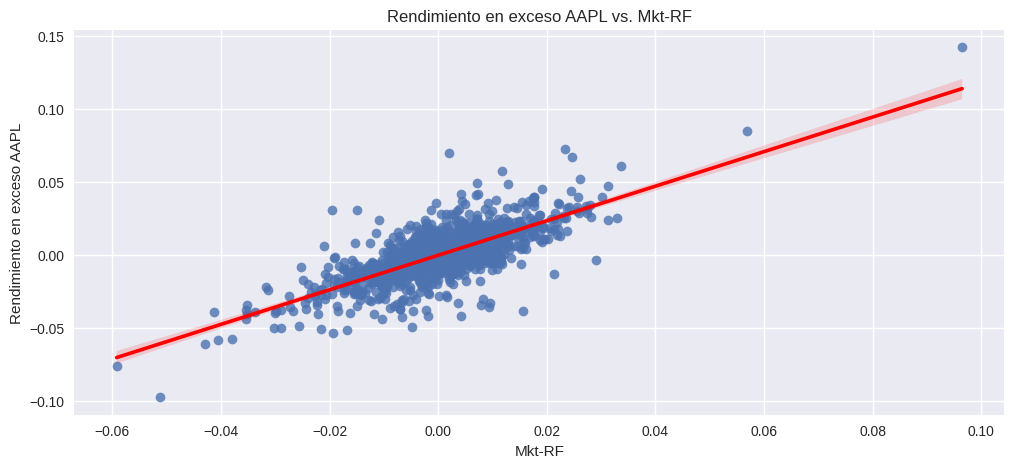

In [168]:
plt.figure(figsize=(12, 5))
sns.regplot(
    x=datos["Mkt-RF"],
    y=datos["rend_exceso_aapl"],
    line_kws={"color": "red"}
)
plt.title("Rendimiento en exceso AAPL vs. Mkt-RF")
plt.xlabel("Mkt-RF")
plt.ylabel("Rendimiento en exceso AAPL")
plt.grid(True)
plt.show()


#Serie: observado vs. predicho

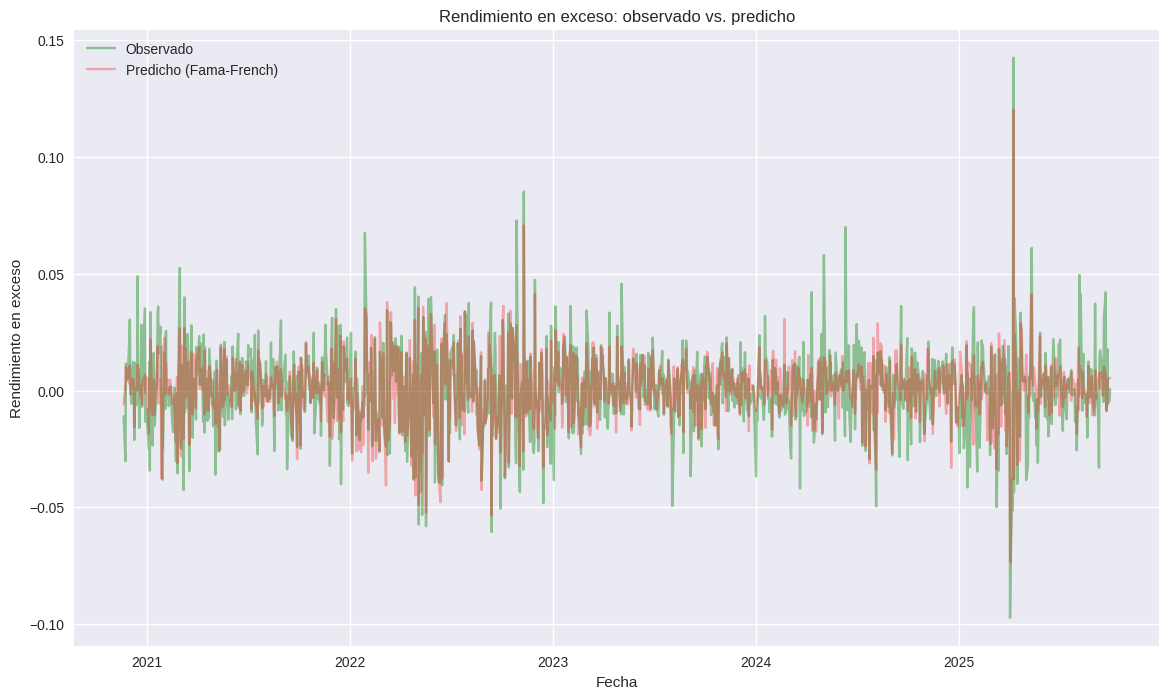

In [164]:
datos["pred_ff"] = modelo.fittedvalues

plt.figure(figsize=(14, 8))
plt.plot(datos.index, datos["rend_exceso_aapl"], label="Observado", alpha=0.4, color="green")
plt.plot(datos.index, datos["pred_ff"], label="Predicho (Fama-French)", alpha=0.3, color="red")
plt.title("Rendimiento en exceso: observado vs. predicho")
plt.ylabel("Rendimiento en exceso")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.show()


#Residuales del modelo

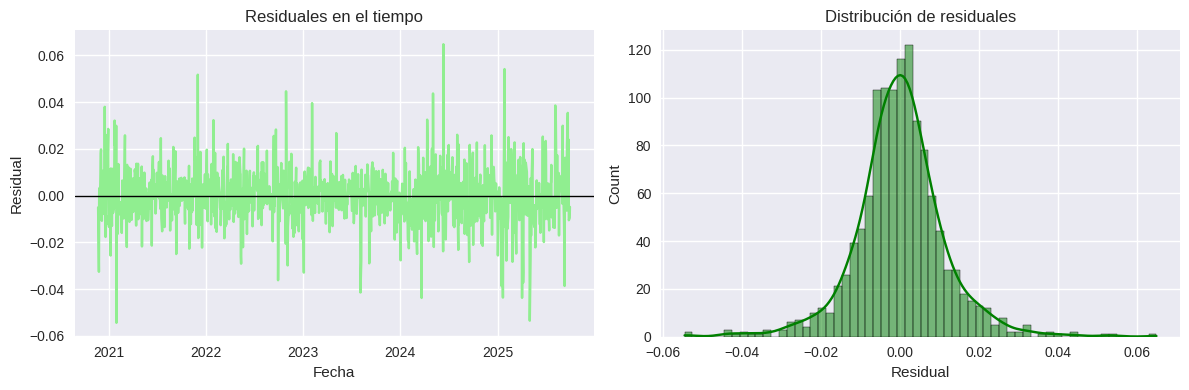

In [167]:
datos["residual"] = modelo.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Serie temporal de residuales
axes[0].plot(datos.index, datos["residual"], color="lightgreen")
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("Residuales en el tiempo")
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Residual")
axes[0].grid(True)

# Histograma de residuales
sns.histplot(datos["residual"], bins=60, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribución de residuales")
axes[1].set_xlabel("Residual")

plt.tight_layout()
plt.show()


#Interpretación final

## Resumen gráfico del modelo

A partir de las gráficas y del modelo:

- El precio de AAPL muestra una clara tendencia de largo plazo, mientras que los rendimientos son ruidosos y aproximadamente centrados en torno a cero.
- Los factores de Fama-French presentan variación diaria alrededor de valores pequeños, típicos de rendimientos.
- La matriz de correlaciones muestra que el rendimiento de AAPL está fuertemente relacionado con la prima de mercado (Mkt-RF), y menos con SMB y HML.
- El modelo Fama-French ajusta bastante bien los rendimientos en exceso de AAPL:
  - El **alpha** es prácticamente cero y no significativo.
  - El beta de **Mkt-RF** es mayor que 1, indicando que AAPL es más sensible que el mercado.
  - El beta de **SMB** es negativo (perfil de large cap).
  - El beta de **HML** es negativo (perfil de growth).
- Los residuales parecen centrados en torno a cero y sin patrones claros en el tiempo, lo que sugiere que el modelo captura bien la estructura principal del riesgo.


